In [1]:
import io
import PIL.Image
import IPython
import cv2
import os
from IPython.display import Image, display, clear_output
import numpy as np
import imageio
import time
import argparse
import base64
from datetime import date
from timeit import default_timer as timer
from queue import Queue
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model


In [2]:
!pip install imageio-ffmpeg 

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [3]:
## Variaveis globais e classificadores

maskmodel = load_model('mask_detector.model')
prototxt = 'deploy.prototxt'
caffemodel = 'res10_300x300_ssd_iter_140000.caffemodel'

net = cv2.dnn.readNetFromCaffe(prototxt,caffemodel)

 
clrs = [
    [(0,255,0),(255,255,0)],
    [(255,127,0),(255,0,0)]
]

fila = Queue(maxsize = 10)

In [4]:
# Como um report iria se comportar
class Report:
    def __init__(self,img,date,people=0,maskoff=0,crowd=0,tipo = 'default'):
        self.img = img
        self.date = date
        self.people = people
        self.maskoff = maskoff
        self.crowd = crowd
        self.tipo = tipo

In [5]:
def showarray(a,fmt = 'jpeg'): # Mostra imagem
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f,fmt)
    display(Image(data=f.getvalue()))

In [6]:
def getReport(): # Pegaria o primeiro alerta da fila
    try:
        alerta = fila.get().__dict__
    except:
        alerta = None
    return alerta

In [7]:
def detect_faces(img,conf): 
    global net
    (h,w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img,(300,300)),1.0,(300,300),(104.0,177.0,123.0))
    
    net.setInput(blob) # Mandando a imagem recortada pra rede
    detections = net.forward() 
    
    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2]
        
        if confidence < conf: # Filtrando as confiaveis
            continue
            
        box = detections[0,0,i,3:7]*np.array([w,h,w,h])
        (startX,startY,endX,endY) = box.astype("int")
        faces.append((startX,startY,endX,endY)) 

    return np.array(faces)

## Funções pra aglomeração

    
  

In [8]:
#Distância Euclidiana Simples
def distance(p1,p2):
    return ((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)**(1/2)

In [9]:
#Pontos que iremos fazer as distâncias euclidianas
def createCenters(faces): 
    centers = [] 
    for frame in faces:
        (sx,sy,ex,ey) = frame
        center = ((sx+ex)/2,(sy+ey)/2)
        centers.append(center)
    return centers

In [10]:
#Criando uma Matriz de distâncias, onde a posição i,j significa a distância do centro da face "i" pra face "j"
def distArr(faces):
    centers = createCenters(faces) 
    n = len(centers)
    dist = np.zeros((n,n))
    for i in range(len(centers)):
        for j in range(len(centers)):
            if i == j:
                continue
            if j > i:
                break
            # A matriz é reflexiva, a distância de "i" pra "j " é igual a distância de "j" pra "i" 
            dist[i][j] = distance(centers[i],centers[j])
            dist[j][i] = dist[i][j] 
    return dist   

In [11]:
# Retorna confiança de que um rosto está com máscara ou não
def hasMask(face):
    global maskmodel
    face = cv2.resize(face, (224, 224))
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)
    return maskmodel.predict(face)[0][0]

In [12]:
# Função pra definir o tipo do alerta:
# caso pelo menos 1 pessoa esteja sem máscara e pelo menos 1 esteja aglomerado na imagem: Sinal Vermelho
# caso ninguém esteja sem máscara e pelo menos 1 esteja aglomerado na imagem: Sinal Amarelo
# caso ninguém esteja sem máscara e ninguém aglomerado na imagem: Sinal Verde
# caso pelo menos 1 pessoa esteja sem máscara e ninguém esteja aglomerado na imagem: Sinal Laranja
def tipo(qtdMaskOff,qtdCrowded):
    if qtdMaskOff and qtdCrowded:
        return 'Vermelho'
    elif not qtdMaskOff and qtdCrowded:
        return 'Amarelo'
    elif not qtdMaskOff and not qtdCrowded:
        return 'Verde'
    else:
        return 'Laranja'

In [13]:
## COLOR
#   0 1   for Green,Yellow,Orange,Red
# 0 G Y 
# 1 O R

#Laranja: Nao aglomerado sem mascara
#Verde: Com mascara e nao aglomerado
#Amarelo: Aglomerado com mascara
#Vermelho: Aglomerado e sem mascara

def clr(maskOff,crowded):
    global clrs
    return clrs[maskOff][crowded]

In [14]:
# Função principal que pega uma imagem, as faces reconhecidas e a matriz de distâncias e retorna
# a imagem com o rosto borrado, um filtro gaussiano, pra preservar identidade.
# a cor do alerta
# a quantidade de pessoas, quantidade sem máscara e quantidade aglomeradas

def rectangles(img,faces,dist,confMask,minDist):
    global numMaskOff
    global numCrowded
    size = len(faces)
    qtdMaskOff = 0
    qtdCrowded = 0
     
    for i in range(size):
        # Cada iteração desse loop significa um rosto
        maskOff = False
        crowded = False
        startX,startY,endX,endY = faces[i]
        face = img[startY:endY,startX:endX]
        img[startY:endY,startX:endX] = cv2.GaussianBlur(face,(21,21),0)
        ## predict mask
        if hasMask(face) < confMask:
            maskOff = True
            qtdMaskOff += 1
        ## Ver aglomeração
        for d in dist[i]:
            # Irei acessar as distâncias daquela pessoa "i" na matriz de distâncias.
            # Pegando a linha "i" e procurando se alguma pessoa em relação a ela tem uma distância menor do que a definida
            # Desconsiderando o 0, já que a distância de "i" pra "i" é zero e não é importante nesse caso.
            if d < minDist and d != 0: 
                crowded = True
                qtdCrowded += 1
                break
        #######
        color = clr(maskOff,crowded)
        img = cv2.rectangle(img,(startX,startY),(endX,endY),color,3)
    return img,size,qtdMaskOff,qtdCrowded

In [15]:
# Pego uma gravação lida com o image.io em ffmpeg, que pega toda a gravação e reparte em uma lista de frames
def show(vid):
    start = timer() # Timer importante para mandar os reports
    for image in vid.iter_data():
        # Analisando pra cada frame
        end = timer()
        image = cv2.medianBlur(image,3)
        faces = detect_faces(image,0.2)
        dist = distArr(faces)
        image,size,qtdMaskOff,qtdCrowded = rectangles(image,faces,dist,0.5,200)
        if end - start > 20:
            t = time.localtime()
            current_time = time.strftime("%H:%M:%S", t)
            data = str(date.today()) + ' ' + str(current_time)
            alert = tipo(qtdMaskOff,qtdCrowded)
            buffer = cv2.imencode('.jpg', image)[1]
            
            if alert == 'Verde': 
                imgb64 = None
            else: # Armazenar imagem para ver possiveis falsos positivos
                imgb64 = base64.b64encode(buffer)
                
            relatorio = Report(imgb64,data,size,qtdMaskOff,qtdCrowded,alert)
            fila.put(relatorio)
            
            # Resetando timer
            start = timer()
            end = timer()
            
            
        showarray(image)
        clear_output(wait=True)


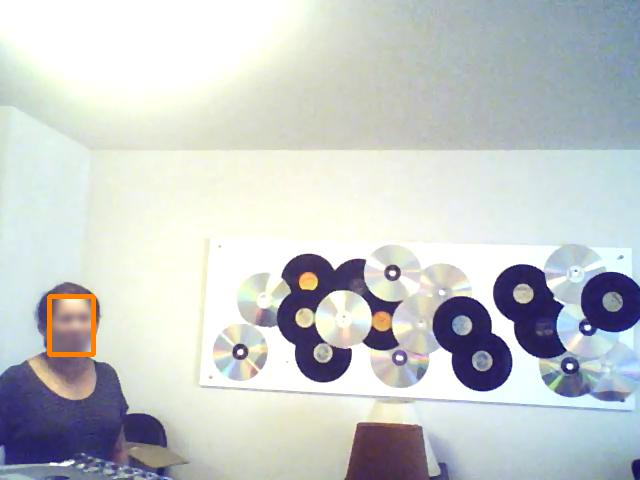

In [16]:
filename = 'video.mp4'
vid = imageio.get_reader(filename,'ffmpeg')
show(vid)

In [17]:
getReport()

{'img': b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBjk5xUbtnmnykg/WoHcY4rSKOStOw13wc1DK4zgmnu2OaqXMrDLCrk+WJ5lSo7kGoS7